/var/folders/0x/cpw5m7p54c7bkvtwg77cln500000gn/T/ipykernel_2693/4203866638.py:156: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu_idea = float(p.T @ mu_stock.values.reshape(-1,1))
/var/folders/0x/cpw5m7p54c7bkvtwg77cln500000gn/T/ipykernel_2693/4203866638.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var_idea = float(p.T @ Sigma_stock.values @ p)
/var/folders/0x/cpw5m7p54c7bkvtwg77cln500000gn/T/ipykernel_2693/4203866638.py:156: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecat

=== Portfolio Simulation Summary ===
Initial Capital: 1e+06
Final Portfolio Value: 986838
Total Return: -0.0131619
Annualized Return: -0.0508315
Annualized Volatility: 0.00127614
Sharpe (ann): -39.8323
Max Drawdown: -0.0131619
Avg Daily Turnover: 0.258744
Total Trades Count (approx): 852
Idea Realizations: 325
Idea Win Rate: 0
Avg Idea Holding (days): 4.90769


/var/folders/0x/cpw5m7p54c7bkvtwg77cln500000gn/T/ipykernel_2693/4203866638.py:156: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu_idea = float(p.T @ mu_stock.values.reshape(-1,1))
/var/folders/0x/cpw5m7p54c7bkvtwg77cln500000gn/T/ipykernel_2693/4203866638.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var_idea = float(p.T @ Sigma_stock.values @ p)
/var/folders/0x/cpw5m7p54c7bkvtwg77cln500000gn/T/ipykernel_2693/4203866638.py:156: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecat

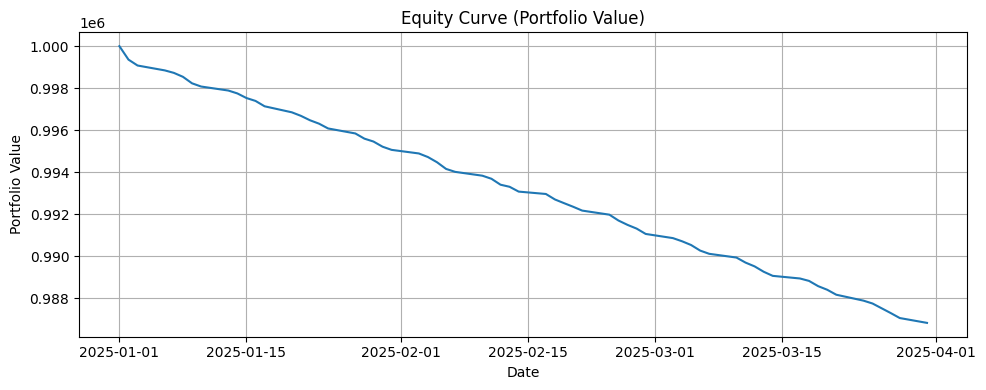

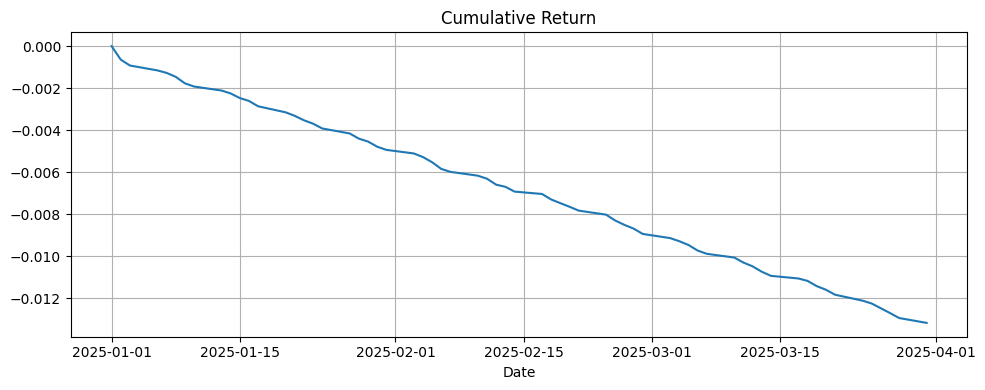

ModuleNotFoundError: No module named 'caas_jupyter_tools'

In [3]:
# Simulate a realistic L/S idea-level portfolio for the given US TMT universe
# - Uses simulated factor-driven prices (Fama-French style + idiosyncratic)
# - Generates ideas (long/short pairs) with conviction levels
# - Dollar-neutral ideas (long = short in dollar)
# - Daily rebalance using MVO (maximize Sharpe via SLSQP) with non-negative idea weights summing to 1
# - Average holding ~5 days, max 22 business days
# - Transaction cost model included
# - Outputs performance stats and plots
# This is a complete runnable simulation. No external data required.

import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import math
import random

np.random.seed(42)
random.seed(42)

# Universe and simulation dates
stocks = [
    "AAPL", "MSFT", "GOOGL", "META", "AMZN", "NVDA", "AMD", "TSM",
    "INTC", "CRM", "ADBE", "ORCL", "NFLX", "QCOM", "SNOW"
]

start = "2025-01-01"
end = "2025-03-31"
# business days (Mon-Fri)
dates = pd.bdate_range(start, end)
n_days = len(dates)
n_stocks = len(stocks)

# Trading calendar mapping date -> index
date_index = {d: i for i,d in enumerate(dates)}

# ----- Simulate factor returns and stock returns via factor model -----
# We'll simulate 5 'Fama-French-like' factors plus market factor (total 5 factors requested)
n_factors = 5

# Choose realistic annual vol for factors (in decimals)
factor_annual_vol = np.array([0.12, 0.10, 0.08, 0.06, 0.05])  # typical factor vols
trading_days = 252
factor_daily_vol = factor_annual_vol / math.sqrt(trading_days)

# Simulate factor correlations (some mild correlation)
corr = np.eye(n_factors) * 0.9 + 0.1
# create covariance
factor_cov = np.diag(factor_daily_vol) @ corr @ np.diag(factor_daily_vol)

# simulate daily factor returns
factor_returns = np.random.multivariate_normal(np.zeros(n_factors), factor_cov, size=n_days)
factor_returns = pd.DataFrame(factor_returns, index=dates, columns=[f"F{i+1}" for i in range(n_factors)])

# Factor loadings B for each stock (random but sensible for TMT).
# Values such that exposures roughly between -1 and +1
B = pd.DataFrame(np.random.normal(0, 0.6, size=(n_stocks, n_factors)), index=stocks, columns=factor_returns.columns)

# Idiosyncratic vol for each stock (annual)
idio_annual_vol = np.random.uniform(0.35, 0.65, size=n_stocks)  # tech tends to be higher vol
idio_daily_vol = idio_annual_vol / math.sqrt(trading_days)

# Simulate stock returns: r = B f + eps
eps = np.random.normal(0, 1, size=(n_days, n_stocks)) * idio_daily_vol
stock_returns = pd.DataFrame(factor_returns.values @ B.T + eps, index=dates, columns=stocks)

# Build stock price series starting prices near realistic levels
start_prices = {
    "AAPL": 160, "MSFT": 410, "GOOGL": 150, "META": 380, "AMZN": 165,
    "NVDA": 420, "AMD": 160, "TSM": 110, "INTC": 36, "CRM": 250,
    "ADBE": 530, "ORCL": 110, "NFLX": 500, "QCOM": 150, "SNOW": 120
}
prices = pd.DataFrame(index=dates, columns=stocks, dtype=float)
prices.iloc[0] = [start_prices[s] for s in stocks]
for i in range(1, n_days):
    prices.iloc[i] = prices.iloc[i-1] * (1 + stock_returns.iloc[i])

# ----- Build stock covariance (Barra-style): Σ = B Σ_f B' + D (diagonal idio var) -----
# Factor covariance estimated from simulated factor_returns
Sigma_f = factor_returns.cov().values  # daily covariance
Sigma_stock = B.values @ Sigma_f @ B.values.T + np.diag(idio_daily_vol**2)
Sigma_stock = pd.DataFrame(Sigma_stock, index=stocks, columns=stocks)

# ----- Idea generation rules -----
# Idea: dict with keys: id, created_date, start_date (trade from next biz day), long, short, conviction, horizon_days, expiry_date, p_vector
idea_counter = 0
def gen_idea(created_date):
    global idea_counter
    idea_counter += 1
    # pick distinct tickers
    long, short = np.random.choice(stocks, size=2, replace=False)
    conviction = np.random.choice([1,2,3,4,5], p=[0.1,0.15,0.3,0.3,0.15])  # more mid conv
    # holding horizon: geometric-like around 5 with cap at 22
    # We'll draw from Poisson+1 then clip
    horizon = int(np.clip(np.random.poisson(4) + 1, 1, 22))
    # ensure average near ~5 by Poisson(4)+1
    # idea_date is created_date, start trading next business day
    created_idx = date_index[created_date]
    start_idx = created_idx + 1
    if start_idx >= n_days:
        start_date = None
        expiry_date = None
    else:
        start_date = dates[start_idx]
        expiry_idx = min(start_idx + horizon - 1, n_days-1)
        expiry_date = dates[expiry_idx]
    # position vector: +0.5 on long, -0.5 on short (dollar-neutral for a unit idea)
    p = pd.Series(0.0, index=stocks)
    p[long] = 0.5
    p[short] = -0.5
    return {
        "id": f"idea_{idea_counter}",
        "created_date": created_date,
        "start_date": start_date,
        "long": long,
        "short": short,
        "conviction": conviction,
        "horizon": horizon,
        "expiry_date": expiry_date,
        "p": p
    }

# Generate initial ideas on first date (they will be tradable from next day)
ideas_master = []
first_date = dates[0]
for _ in range(10):
    ideas_master.append(gen_idea(first_date))

# Simulation parameters
initial_capital = 1_000_000.0
tc_bps = 0.0005  # 5 bps transaction cost per traded dollar
slippage_bps = 0.0003  # additional slippage per traded dollar
daily_records = []

# Track active ideas (by id -> idea dict with entry_date and remaining)
active_ideas = {}
# Keep history of idea lifetimes and realized returns
idea_history = []

# Helper: compute idea-level expected return and variance
# We'll use stock expected returns estimated from recent window of simulated stock_returns (say last 21 days)
def estimate_stock_expected_returns(as_of_date, lookback=21):
    # use previous lookback days ending at as_of_date-1
    idx = date_index[as_of_date]
    start_idx = max(0, idx - lookback)
    if start_idx == idx:
        # insufficient history, use zeros
        return pd.Series(0.0, index=stocks)
    sample = stock_returns.iloc[start_idx:idx]
    return sample.mean()

# For idea-level mu and variance given stock-level mu and Sigma_stock
def idea_stats(idea, mu_stock, Sigma_stock):
    p = idea["p"].values.reshape(-1,1)
    mu_idea = float(p.T @ mu_stock.values.reshape(-1,1))
    var_idea = float(p.T @ Sigma_stock.values @ p)
    return mu_idea, var_idea

# Optimization: maximize Sharpe = (w^T mu) / sqrt(w^T Sigma w)
# We'll solve by minimizing negative Sharpe with constraints sum(w)=1 and w>=0
def optimize_weights(mu_vec, cov_mat):
    # mu_vec: array shape (n_ideas,), cov_mat: (n_ideas,n_ideas)
    n = len(mu_vec)
    if n == 0:
        return np.array([])
    # if all mu are zero or covariance singular, give equal weights
    try:
        # initial guess
        x0 = np.ones(n) / n
        bounds = [(0.0,1.0) for _ in range(n)]
        cons = ({'type':'eq', 'fun': lambda x: np.sum(x) - 1.0},)
        def neg_sharpe(x):
            port_mu = x @ mu_vec
            port_var = x @ cov_mat @ x
            if port_var <= 0:
                return 1e6
            return - port_mu / np.sqrt(port_var)
        res = minimize(neg_sharpe, x0, bounds=bounds, constraints=cons, method='SLSQP', options={'ftol':1e-9, 'maxiter':500})
        if not res.success:
            # fallback: equal weights
            return np.ones(n) / n
        w = np.clip(res.x, 0, 1)
        # renormalize to sum 1 in case of numerical slack
        if w.sum() == 0:
            return np.ones(n) / n
        return w / w.sum()
    except Exception as e:
        return np.ones(n) / n

# Keep track of positions state per stock (dollar amount)
positions = pd.Series(0.0, index=stocks)  # current dollar positions (long positive, short negative)

portfolio_value = initial_capital
cash = initial_capital
total_turnover = 0.0
trade_count = 0

# We'll maintain a DataFrame of daily portfolio value, PnL, returns
pf_daily = pd.DataFrame(index=dates, columns=["portfolio_value", "cash", "positions_pnl", "transaction_costs", "total_pnl", "ret"], dtype=float)

# For idea lifecycle tracking
idea_entry_info = {}  # idea_id -> dict of entry_date, entry_allocation ($), entry_positions (dollar allocation per stock)

# Main simulation loop over dates
for t, current_date in enumerate(dates):
    # 1) On each day, generate 5 new ideas (these will be tradable from next trading day)
    for _ in range(5):
        ideas_master.append(gen_idea(current_date))
    # 2) Activate ideas whose start_date == current_date (i.e., they become tradable today)
    for idea in ideas_master:
        if idea["start_date"] is not None and idea["start_date"] == current_date:
            active_ideas[idea["id"]] = idea.copy()
            # set remaining expiry already present in idea
        
    # 3) Remove expired ideas (if expiry_date < current_date)
    expired_ids = [iid for iid,idea in active_ideas.items() if idea["expiry_date"] is not None and idea["expiry_date"] < current_date]
    for iid in expired_ids:
        # unwind positions for this idea if it currently has an active allocation
        if iid in idea_entry_info:
            # remove from entry_info - we'll rebalance below which will zero this idea
            del idea_entry_info[iid]
        # record idea as expired
        idea_obj = active_ideas.pop(iid)
        idea_obj['status'] = 'expired'
        idea_history.append(idea_obj)
    
    # 4) Prepare optimization inputs: for each active idea, compute mu_idea and cov matrix between ideas
    # Only include ideas that have start_date <= current_date <= expiry_date
    todays_active = {iid: idea for iid, idea in active_ideas.items() if idea["start_date"] is not None and idea["start_date"] <= current_date and idea["expiry_date"] is not None and idea["expiry_date"] >= current_date}
    idea_ids = list(todays_active.keys())
    n_active = len(idea_ids)
    
    if n_active == 0:
        # no investment today, mark portfolio value based on positions pnl only
        # compute positions PnL from price move today (if t>0)
        if t == 0:
            pf_daily.loc[current_date, ["portfolio_value","cash","positions_pnl","transaction_costs","total_pnl","ret"]] = [portfolio_value, cash, 0.0, 0.0, 0.0, 0.0]
            continue
        # compute PnL from yesterday positions
        ret_series = (prices.iloc[t] / prices.iloc[t-1] - 1.0).astype(float)
        positions_pnl = (positions * ret_series).sum()
        portfolio_value = cash + positions.sum() + positions_pnl  # positions are mark-to-market in positions? Actually positions stores dollar exposure at previous close
        total_pnl = positions_pnl
        pf_daily.loc[current_date, ["portfolio_value","cash","positions_pnl","transaction_costs","total_pnl","ret"]] = [portfolio_value, cash, positions_pnl, 0.0, total_pnl, total_pnl/ (portfolio_value - total_pnl)]
        continue
    
    # Estimate stock-level expected returns using recent lookback ending yesterday
    if t == 0:
        mu_stock = pd.Series(0.0, index=stocks)
    else:
        mu_stock = estimate_stock_expected_returns(current_date, lookback=21)
    
    # Idea-level mus and cov
    mu_ideas = []
    p_matrix = []
    for iid in idea_ids:
        idea = todays_active[iid]
        base_mu, var_idea = idea_stats(idea, mu_stock, Sigma_stock)
        # Convert base_mu into a conviction-scaled expected return (conviction 1-5)
        # We also add a small signal proportional to difference in historical performance of long vs short
        # Compute simple mean return differential over lookback
        if t>0:
            long_hist = stock_returns[idea["long"]].iloc[max(0,t-21):t].mean()
            short_hist = stock_returns[idea["short"]].iloc[max(0,t-21):t].mean()
            hist_diff = long_hist - short_hist
        else:
            hist_diff = 0.0
        # combine signals: conviction scales the hist_diff and base_mu; keep magnitude modest
        mu_i = (idea["conviction"]/5.0) * (0.5 * base_mu + 1.5 * hist_diff)
        # if mu_i is extremely small, keep tiny noise to allow diversification
        mu_ideas.append(mu_i)
        p_matrix.append(idea["p"].values)
    mu_ideas = np.array(mu_ideas)
    P = np.vstack(p_matrix)  # (n_active, n_stocks)
    # idea covariance: Cov(ideas) = P Sigma_stock P^T  (since ideas are linear combos)
    cov_ideas = P @ Sigma_stock.values @ P.T
    
    # Regularize cov_ideas slightly for numerical stability
    cov_ideas += np.eye(n_active) * 1e-8
    
    # 5) Optimize idea weights given mu_ideas and cov_ideas
    weights = optimize_weights(mu_ideas, cov_ideas)
    
    # 6) Convert idea weights into stock-level dollar target positions
    # For idea weight w_i and portfolio_value, allocate w_i * portfolio_value to idea.
    # Idea's p vector has +0.5/-0.5 normalized; so dollar positions = idea_alloc * p * 2 ?
    # We used p where long=+0.5 and short=-0.5 so that sum of absolute positions = 1.0 of idea_alloc.
    # So dollar position per stock = idea_alloc * p * 1.0*1 (long 0.5 * idea_alloc = long $)
    # Set desired_positions_dollar = sum across ideas of idea_alloc * p
    idea_allocations = pd.Series(weights * portfolio_value, index=idea_ids)
    desired_positions = pd.Series(0.0, index=stocks)
    for iid, w in zip(idea_ids, weights):
        idea = todays_active[iid]
        desired_positions += idea["p"] * (w * portfolio_value)
    # desired_positions is dollar exposure per stock
    
    # 7) Compute trades (differences) and transaction costs to move from current positions to desired_positions
    trades = desired_positions - positions  # dollar trades (signed)
    trade_volume = trades.abs().sum()  # total traded dollar volume
    tc = trade_volume * tc_bps + trade_volume * slippage_bps
    total_turnover += trade_volume / (portfolio_value if portfolio_value>0 else 1.0)
    trade_count += int((trades != 0).sum())
    
    # Adjust cash for trades and transaction costs
    cash -= trades.sum()  # trades sum should be ~0 if dollar-neutral overall, but numerical quirks possible
    cash -= tc
    # Update positions
    positions = desired_positions.copy()
    
    # 8) Mark-to-market PnL from price moves today (if t>0)
    if t == 0:
        positions_pnl = 0.0
        total_pnl = -tc  # pay tc on first entry
    else:
        # compute returns from yesterday close to today's close
        ret_series = (prices.iloc[t] / prices.iloc[t-1] - 1.0).astype(float)
        # positions are dollar exposures held from previous close; since we rebalanced at today's open using target positions based on today's prices,
        # we'll approximate PnL using price moves for today's positions relative to previous close:
        positions_pnl = (positions.shift(0).fillna(0) * ret_series).sum()
        total_pnl = positions_pnl - tc
    
    portfolio_value = cash + positions.sum()  # mark-to-market: positions sum is current market value
    # compute return for day
    if t==0:
        daily_ret = 0.0
    else:
        prev_val = pf_daily["portfolio_value"].iloc[t-1]
        if prev_val == 0:
            daily_ret = 0.0
        else:
            daily_ret = (portfolio_value - prev_val) / prev_val
    
    pf_daily.loc[current_date, ["portfolio_value","cash","positions_pnl","transaction_costs","total_pnl","ret"]] = [
        portfolio_value, cash, positions_pnl, tc, total_pnl, daily_ret
    ]
    
    # 9) Record entry allocations for ideas in case needed to compute realized returns later
    # We'll store idea_entry_info for active ideas with non-zero allocation
    for iid, alloc in idea_allocations.items():
        if alloc > 0:
            idea_entry_info[iid] = {
                "entry_date": current_date,
                "entry_allocation": alloc,
                "entry_positions": (todays_active[iid]["p"] * alloc).to_dict()
            }
    # 10) For ideas that expired today, we capture final status in history
    to_remove = []
    for iid, info in idea_entry_info.items():
        idea_obj = active_ideas.get(iid)
        if idea_obj is None:
            # already removed earlier as expired
            to_remove.append(iid)
            continue
        if idea_obj["expiry_date"] == current_date:
            # record realized PnL for the idea by computing pnl from entry to today across its positions
            entry_pos = pd.Series(info["entry_positions"])
            # compute return from entry_date to today using price series
            entry_idx = date_index[info["entry_date"]]
            today_idx = t
            # compute multiplicative returns across days
            price_start = prices.iloc[entry_idx]
            price_end = prices.iloc[t]
            # PnL in dollars = sum(entry_pos * (price_end/price_start - 1))
            ret_by_stock = price_end / price_start - 1.0
            realized_pnl = (entry_pos * ret_by_stock).sum()
            idea_obj['realized_pnl'] = realized_pnl
            idea_obj['status'] = 'realized'
            idea_history.append(idea_obj)
            to_remove.append(iid)
    for iid in to_remove:
        if iid in idea_entry_info:
            del idea_entry_info[iid]
        if iid in active_ideas:
            del active_ideas[iid]

# Simulation done - compute performance metrics
pf_daily["cumret"] = pf_daily["portfolio_value"] / initial_capital - 1.0
daily_rets = pf_daily["ret"].fillna(0.0)

def annualize_return(cum_ret, days):
    return (1 + cum_ret) ** (252/days) - 1 if days>0 else 0.0

total_days = n_days
total_cum = pf_daily["cumret"].iloc[-1]
ann_return = annualize_return(total_cum, total_days)
ann_vol = daily_rets.std() * math.sqrt(252)
sharpe = ann_return / ann_vol if ann_vol>0 else np.nan
# max drawdown
running_max = pf_daily["portfolio_value"].cummax()
drawdown = (pf_daily["portfolio_value"] - running_max) / running_max
max_dd = drawdown.min()

# Turnover: average daily turnover
avg_daily_turn = total_turnover / n_days

# Win rate of idea_history realized_pnl
realized = [h for h in idea_history if 'realized_pnl' in h]
wins = sum(1 for h in realized if h['realized_pnl'] > 0)
win_rate = wins / len(realized) if len(realized)>0 else np.nan

# Average holding period
holdings = [h['horizon'] for h in realized if 'realized_pnl' in h]
avg_hold = np.mean(holdings) if len(holdings)>0 else np.nan

# Basic stats dataframe
stats = {
    "Initial Capital": initial_capital,
    "Final Portfolio Value": pf_daily["portfolio_value"].iloc[-1],
    "Total Return": total_cum,
    "Annualized Return": ann_return,
    "Annualized Volatility": ann_vol,
    "Sharpe (ann)": sharpe,
    "Max Drawdown": max_dd,
    "Avg Daily Turnover": avg_daily_turn,
    "Total Trades Count (approx)": trade_count,
    "Idea Realizations": len(realized),
    "Idea Win Rate": win_rate,
    "Avg Idea Holding (days)": avg_hold
}

# Print results and show plots
print("=== Portfolio Simulation Summary ===")
for k,v in stats.items():
    if isinstance(v, float):
        print(f"{k}: {v:.6g}")
    else:
        print(f"{k}: {v}")
        
# show cumulative equity curve
plt.figure(figsize=(10,4))
plt.plot(pf_daily.index, pf_daily["portfolio_value"])
plt.title("Equity Curve (Portfolio Value)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.tight_layout()
plt.show()

# show daily returns histogram and rolling metrics
plt.figure(figsize=(10,4))
plt.plot(pf_daily.index, pf_daily["cumret"])
plt.title("Cumulative Return")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()

# Display recent performance table
summary_table = pf_daily[["portfolio_value","cash","positions_pnl","transaction_costs","total_pnl","ret"]].copy()
summary_table["date"] = summary_table.index
summary_table = summary_table.reset_index(drop=True).tail(20)
import caas_jupyter_tools as cjt
cjt.display_dataframe_to_user("Recent 20 Trading Days (Portfolio)", summary_table)

# Also prepare idea-level summary
import json
idea_df = pd.DataFrame([{
    "id": h.get("id"),
    "long": h.get("long"),
    "short": h.get("short"),
    "conviction": h.get("conviction"),
    "horizon": h.get("horizon"),
    "realized_pnl": h.get("realized_pnl", np.nan),
    "status": h.get("status", "")
} for h in idea_history])

cjt.display_dataframe_to_user("Idea History Summary", idea_df.head(50))

# Save final outputs for user download if desired
pf_daily.to_csv("/mnt/data/portfolio_daily.csv")
idea_df.to_csv("/mnt/data/idea_history.csv")

print("\nSaved /mnt/data/portfolio_daily.csv and /mnt/data/idea_history.csv")


In [4]:
!uv pip show jupyter-analysis-tools


Name: jupyter-analysis-tools
Version: 1.6.2
Location: /Users/xiaohui/Documents/git_repo/quant-factor-analysis/.venv/lib/python3.13/site-packages
Requires: ipywidgets, matplotlib, numpy, pandas, pybis, scipy
Required-by:
